# **1. Importación de *modules***

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import scale

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti_tp2.csv***

In [2]:
data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
data.head(3)
data.shape

,sup_total,sup_cubierta,precio_por_m2,habitaciones,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,...,pn_Villa de Mayo,pn_Villa del Parque,pn_Village Golf & Tennis Country Club,pn_Virasoro Village,pn_Virrey del Pino,pn_Virreyes,pn_Wilde,pn_William Morris,pn_Zelaya,pn_coordenadas 34.255511
0,55.0,40.0,1127.272727,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,55.0,55.0,1309.090909,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106.0,78.0,1226.415094,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(41760, 467)

# **3. Tratamiento de los datos**

<AxesSubplot:>

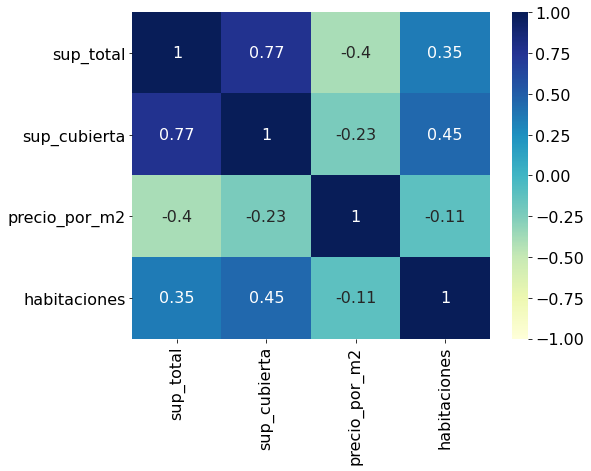

In [3]:
# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
sns.heatmap(data.iloc[:, :4].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

# **4.Modelos**

## **4.1 Regresión lineal simple (RLS)**

#### 4.1.1 funcion rls_func

In [4]:
def rls_func(X,y,columna):
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage    shuffle=False
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1, shuffle = False)
    lm = LinearRegression() # Fiteamos el modelo sobre los vectores X e y.
    model = lm.fit(Xtrain, ytrain)
    print(f'''    Coef\t{model.coef_}''')
    print(f'''    intercept\t{model.intercept_}''')
    test_sklearn = np.array(Xtest).reshape(-1,1)
    ypred = model.predict(test_sklearn)
    
    print(f'''    MAE\t{mean_absolute_error(ytest, ypred).round(2)}
    MSE\t{mean_squared_error(ytest, ypred).round(2)}
    RMSE\t{np.sqrt(mean_squared_error(ytest, ypred)).round(2)}
    R2\t{r2_score(ytest, ypred).round(2)}
    ''')

    sns.regplot(data = data, x = columna, y = 'precio_por_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})
    #return mean_absolute_error(y_test, y_pred)


### Regresión lineal simple (RLS) de a una feature a la vez **sin normalización**

#### 4.1.2 scater plot

Text(0.5, 0, 'SurfTot ')

Text(0, 0.5, 'PUPM ')

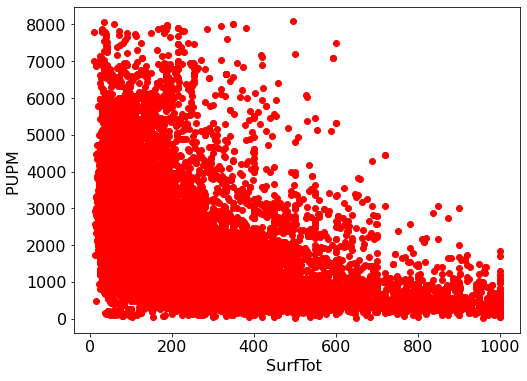

In [5]:
#sup_total
xs = data[["sup_total"]]
ys = data["precio_por_m2"]

plt.scatter(xs, ys, color='r')
plt.xlabel("SurfTot ")
plt.ylabel("PUPM ")
plt.show()

#### 4.1.3 Superficie total

*** Superficie total ***
    Coef	[-2.55169521]
    intercept	2444.4350213714215
    MAE	697.94
    MSE	959607.11
    RMSE	979.6
    R2	0.08
    


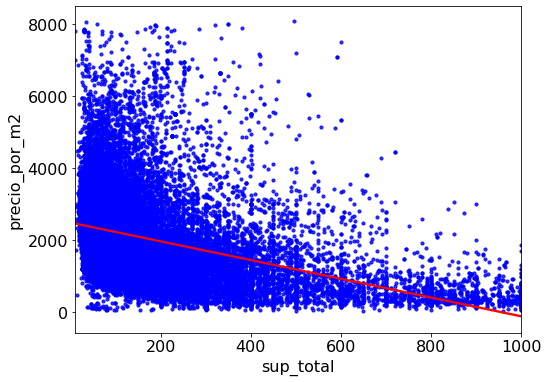

In [6]:
# Superficie total
print("*** Superficie total ***")
X = data[['sup_total']]
y = data['precio_por_m2']
rls_func(X,y,'sup_total')


#### 4.1.4 Superficie cubierta

*** Superficie cubierta ***
    Coef	[-2.59902542]
    intercept	2329.6847507329676
    MAE	724.28
    MSE	1034446.39
    RMSE	1017.08
    R2	0.01
    


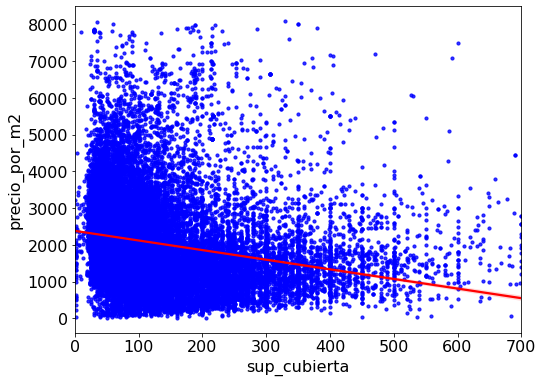

In [7]:
# Superficie cubierta
print("*** Superficie cubierta ***")
X = data[['sup_cubierta']]
y = data['precio_por_m2']
rls_func(X,y,'sup_cubierta')


#### 4.1.5 Habitaciones

*** habitaciones ***
    Coef	[-108.41659793]
    intercept	2329.364270044032
    MAE	759.86
    MSE	1096150.33
    RMSE	1046.97
    R2	-0.05
    


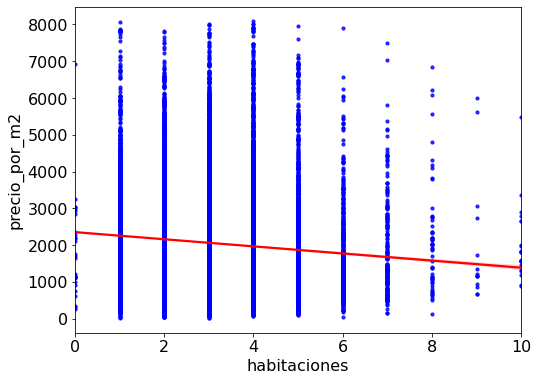

In [8]:
# Habitaciones
print("*** habitaciones ***")
X = data[['habitaciones']]
y = data['precio_por_m2']
rls_func(X,y,'habitaciones')

### RLS a una feature a la vez **normalizando** (usando Scale)

#### 4.1.6 scater plot

Text(0.5, 0, 'SurfTot standardized')

Text(0, 0.5, 'PUPM standardized')

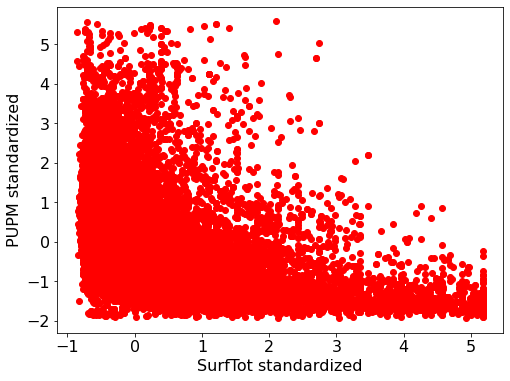

In [9]:
#Normalizo con sup_total
xs = scale(data[["sup_total"]])
ys = scale(data["precio_por_m2"])

plt.scatter(xs, ys, color='r')
plt.xlabel("SurfTot standardized")
plt.ylabel("PUPM standardized")
plt.show()

#### 4.1.7 Superficie total

*** Superficie total con  Normalizacion  ***
    Coef	[-0.38994141]
    intercept	-0.031863835343525895
    MAE	0.65
    MSE	0.83
    RMSE	0.91
    R2	0.08
    


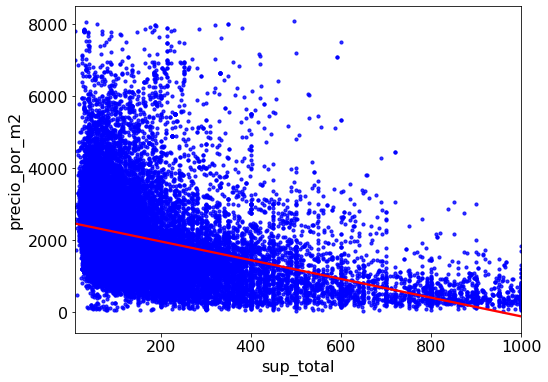

In [10]:
# Normalizo con sup_total
print("*** Superficie total con  Normalizacion  ***")
X = scale(data[["sup_total"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'sup_total')

Comparando los resultados de la regresion lineal simple usando sup_total con y sin normalizacion se tiene:
Sin normalización: 
- MAE	700.94
- MSE	944445.18
- RMSE	971.83
- R2	0.16

Con Normalización
- MAE	0.65
- MSE	0.82
- RMSE	0.91
- R2	0.16

#### 4.1.8 Superficie cubierta

*** Superficie totalcon  Normalizacion  ***
    Coef	[-0.2316544]
    intercept	-0.046991264439856045
    MAE	0.67
    MSE	0.9
    RMSE	0.95
    R2	0.01
    


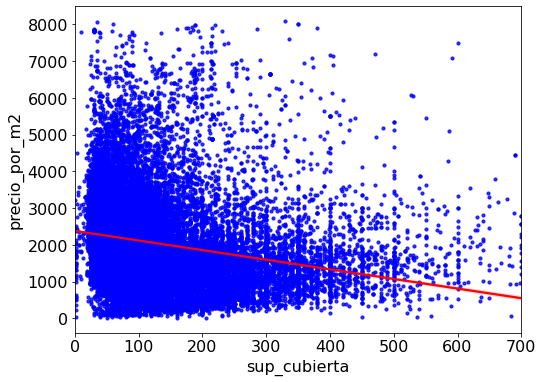

In [11]:
# Normalizo con ssup_cubierta
print("*** Superficie totalcon  Normalizacion  ***")
X = scale(data[["sup_cubierta"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'sup_cubierta')

#### 4.1.9 Habitaciones

*** habitaciones  ***
    Coef	[-0.12298565]
    intercept	-0.05134428905638345
    MAE	0.71
    MSE	0.95
    RMSE	0.98
    R2	-0.05
    


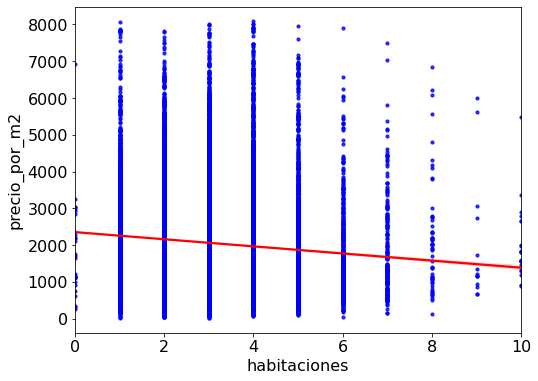

In [12]:
# Normalizo con habitaciones
print("*** habitaciones  ***")
X = scale(data[["habitaciones"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'habitaciones')

## **4.3 Regresión lineal múltiple (RLM)**

### 4.3.1 funcion que tome features y aplique RLM (rlm_func y rlm_func_orig)

In [13]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def rlm_func(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
        
    n = len(y_train)
    p = X_train.shape[1]
    R2 = r2_score(y_test, y_pred)
    R2_ajustado = 1 - (1 - R2)*((n-1)/(n - p - 1))
    
    print(f'''    
    Intercepto\t{linreg.intercept_.round(4)}
    MAE\t\t{mean_absolute_error(y_test, y_pred).round(4)}
    MSE\t\t{mean_squared_error(y_test, y_pred).round(4)}
    RMSE\t{np.sqrt(mean_squared_error(y_test, y_pred)).round(4)}
    R2\t\t{(R2).round(4)}
    R2ADJ\t{(R2_ajustado).round(4)}
    ''')

    plt.plot(y,y, '-.',c='grey')
    plt.scatter(y_pred, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicciones usando todas las variables")
    plt.ylabel("Valores reales ")
    plt.title('Prediccion de precio por m$^2$ utilizando RLM')
    plt.show()

### 4.3.2 RLM con las 3 features originales juntas **sin normalización**

    
    Intercepto	2383.5634
    MAE		705.1884
    MSE		954164.5861
    RMSE	976.8135
    R2		0.0867
    R2ADJ	0.0866
    


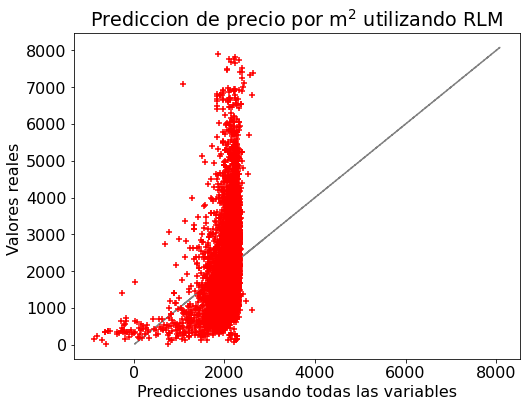

In [14]:
feature_cols = ['sup_total','sup_cubierta','habitaciones']
X = data[feature_cols]
y = data.precio_por_m2
rlm_func(X, y)

### 4.3.3 RLM con las 3 features originales juntas **Con normalización**  (usando Scale)

    
    Intercepto	-0.0299
    MAE		0.6567
    MSE		0.8275
    RMSE	0.9097
    R2		0.0867
    R2ADJ	0.0866
    


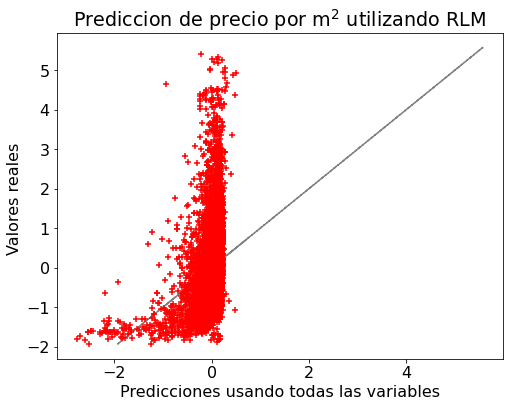

In [15]:
feature_cols =['sup_total','sup_cubierta','habitaciones']
xs_orig = scale(data[feature_cols])
ys_orig = scale(data["precio_por_m2"])

rlm_func(xs_orig,ys_orig)

###  4.3.4 RLM con TODOS los features (excluyendo place_name) **sin normalizar**

    
    Intercepto	1430.748
    MAE		552.7597
    MSE		613603.7786
    RMSE	783.3287
    R2		0.4126
    R2ADJ	0.4122
    


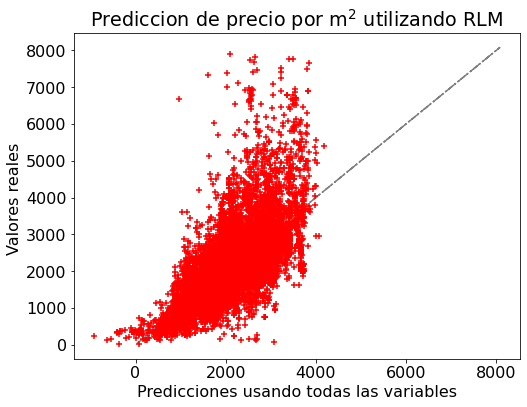

In [16]:
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X_am = data.drop(columns = cols2drop)
y_am = data['precio_por_m2']
rlm_func(X_am, y_am)

### 4.3.5 RLM con TODOS los features (excluyendo place_name) **con normalizacion**  (usando Scale)

    
    Intercepto	-0.0075
    MAE		0.5148
    MSE		0.5322
    RMSE	0.7295
    R2		0.4126
    R2ADJ	0.4122
    


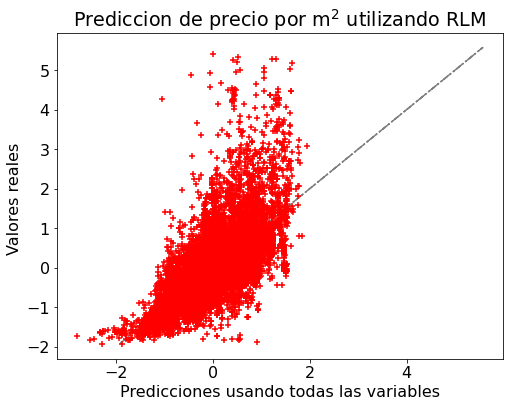

In [17]:
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
Xs_am = scale(data.drop(columns = cols2drop))
ys_am = scale(data['precio_por_m2'])
rlm_func(Xs_am, ys_am)

##  **4.4 Regularización**

### Ridge Regression

In [27]:
# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo.
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Ridge
ridge = Ridge(alpha=0.5, normalize=False)
ridge.fit(X_train,y_train)
ypred_ridge = ridge.predict(X_test)

#Modelo Ridge CV
rlmcv = RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 1, 15, 20, 25, 26, 27, 28, 29, 30,31, 32, 33, 34, 35],\
                                        normalize = False, cv = 5,scoring='r2')
rlmcv.fit(X_train, y_train)
ypred_ridgecv = rlmcv.predict(X_test)


print ('R2:', r2_score(y_test, ypred))
print ("R2_Ridge:", r2_score(y_test, ypred_ridge))
print ("R2_Ridge_CV:", r2_score(y_test, ypred_ridgecv))
print ("Best alpha:", rlmcv.alpha_)

Ridge(alpha=0.5)

RidgeCV(alphas=array([1.0e-05, 5.0e-05, 1.0e-04, 5.0e-04, 1.0e-03, 5.0e-03, 1.0e-02,
       5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 1.0e+00, 1.5e+01, 2.0e+01,
       2.5e+01, 2.6e+01, 2.7e+01, 2.8e+01, 2.9e+01, 3.0e+01, 3.1e+01,
       3.2e+01, 3.3e+01, 3.4e+01, 3.5e+01]),
        cv=5, scoring='r2')

R2: 0.4926039424078016
R2_Ridge: 0.4926039791370075
R2_Ridge_CV: 0.4926049104971897
Best alpha: 25.0


### Regression Lasso

In [21]:
from sklearn.linear_model import LassoCV

# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Lasso
lasso = Lasso(alpha=0.5, normalize=False)
lasso.fit(X_train,y_train)
ypred_lasso = lasso.predict(X_test)

#Modelo Lasso CV
lassocv = LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 
lassocv.fit(X_train, y_train)
ypred_lassocv = lassocv.predict(X_test)

print ('R2:', r2_score(y_test, ypred))
print ("R2_Lasso:", r2_score(y_test, ypred_lasso))
print ("R2_Lasso_CV:", r2_score(y_test, ypred_lassocv))
print ("Best alpha:", lassocv.alpha_)

Lasso(alpha=0.5)

LassoCV(alphas=[1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1,
                5, 10],
        cv=5)

R2: 0.4854284046063225
R2_Lasso: 0.03368310424745102
R2_Lasso_CV: 0.4854191323981141
Best alpha: 0.0005


### Elastic Net

In [22]:
from sklearn.linear_model import ElasticNetCV

# hago regularización con las 3 columnas originales + amenities
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X = scale(data.drop(columns = cols2drop))
y = scale(data['precio_por_m2'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo elastic Net
elastic_net = ElasticNet(alpha=0.5, normalize=False)
elastic_net.fit(X_train, y_train)
ypred_elastic = elastic_net.predict(X_test)

#Modelo elastic Net CV
elasticcv = ElasticNetCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 
elasticcv.fit(X_train, y_train)
ypred_elasticcv = elasticcv.predict(X_test)

print ('R2:', r2_score(y_test, ypred))
print ("R2_Elastic:", r2_score(y_test, ypred_elastic))
print ("R2_Elastic_CV:", r2_score(y_test, ypred_elasticcv))
print ("Best alpha:", elasticcv.alpha_)

ElasticNet(alpha=0.5)

ElasticNetCV(alphas=[1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                     0.1, 1, 5, 10],
             cv=5)

R2: 0.49618605690337814
R2_Elastic: 0.23175848235349716
R2_Elastic_CV: 0.4962942232103128
Best alpha: 0.001


# **5.Supuestos de Markov**

Esta validación de supuestos fue implementado previo a los testeos de distintos modelos pero a los fines de estructurar la notebook los dejamos al final.

1. Linearidad de los parámetros
2. Los estimadores de los parámetros poblacionales se estiman a partir de una muestra aleatoria.
3. No hay colinealidad perfecta entre las variables explicativas.
4. El valor esperado del error es 0 para cualquier valor de la variable explicativa.
5. Homocedasticidad
6. Normalidad de los errores.
7. Independencia de los errores

## Linearidad del modelo

Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

Observar un patrón "inclinado" indica que el modelo comete errores sistemáticos cada vez que realiza predicciones inusualmente grandes o pequeñas. Cuando el modelo contiene muchas características, la no linealidad también se puede revelar mediante patrones sistemáticos en las gráficas de los residuos frente a las características individuales.

Posibles soluciones:

- Transformaciones no lineales sobre las variables dependientes/independiente.
- Agregar features con transformaciones (por ejemplo una version de la variable al cuadrado, o arcsin, logaritmica, etc)
- Agregar features que no fueron considerados actualemente.

In [21]:
#linearidad del modelo
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(features, target):
    X = data[features]
    y = data[target]

    # Tenemos que agregar explícitamente a una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y,X).fit()
    
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')
    

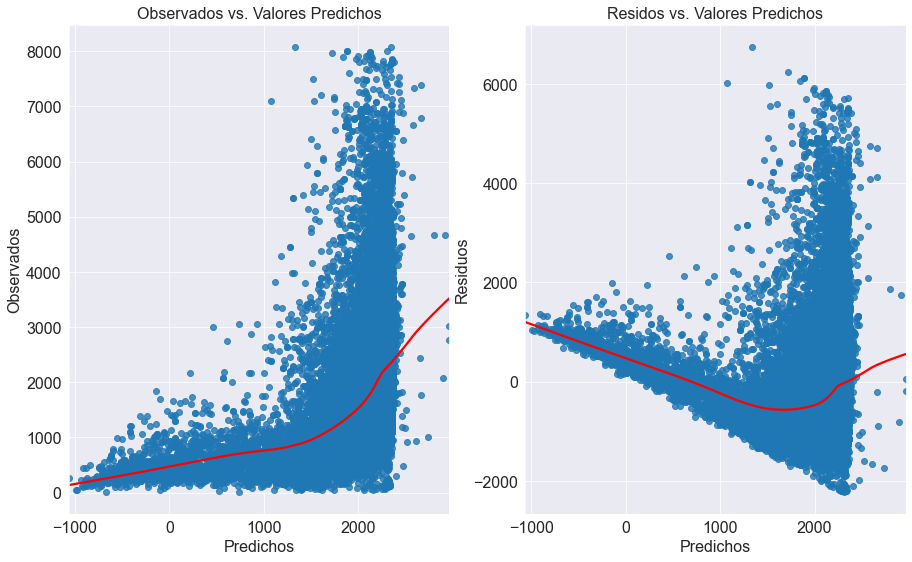

In [23]:
linearity_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])  

## Media de los errores

In [24]:
X = data[['sup_total','sup_cubierta','habitaciones']]
y = data["precio_por_m2"]
model = sm.OLS(y,X).fit()
model.resid.mean()

408.6906021537015

## Valor esperado de los errores

In [25]:
def residuals_test(features, target):
  X = data[features]
  y = data[target]

  # Tenemos que agregar explícitamente a una constante:
  X = sm.add_constant(X)

  model = sm.OLS(y, X).fit()
  residuals = model.resid

  p = sns.scatterplot(data = data, x = data[features], y = residuals);
  p.axhline(0, color = "green")
  p.set(ylabel = "Residuals");

  # otra opción:
  #sns.residplot(data = advertising, x = "TV", y = "Sales");

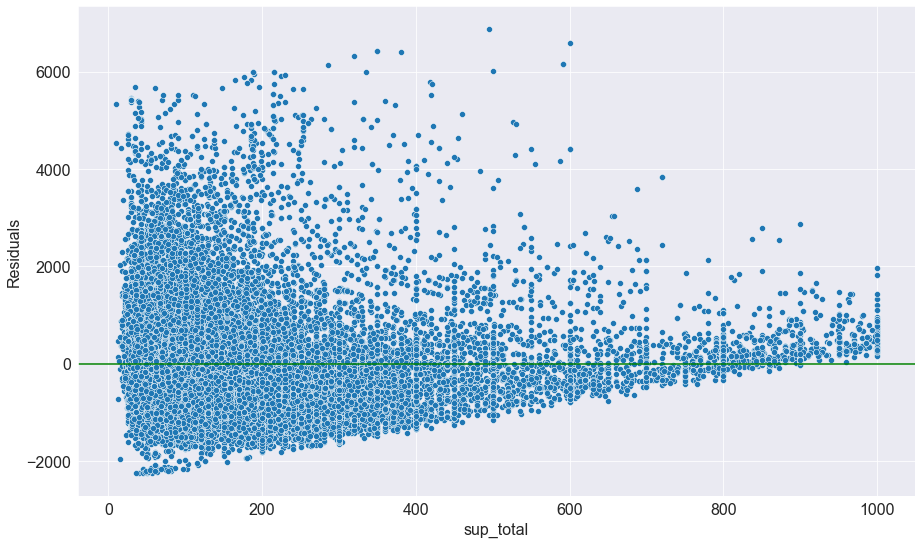

In [26]:
residuals_test('sup_total', "precio_por_m2")

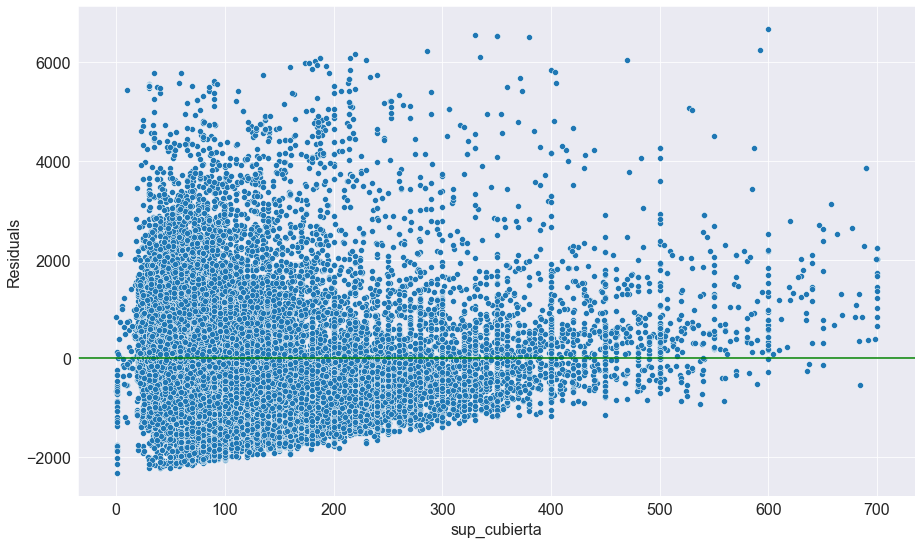

In [27]:
residuals_test('sup_cubierta',"precio_por_m2")

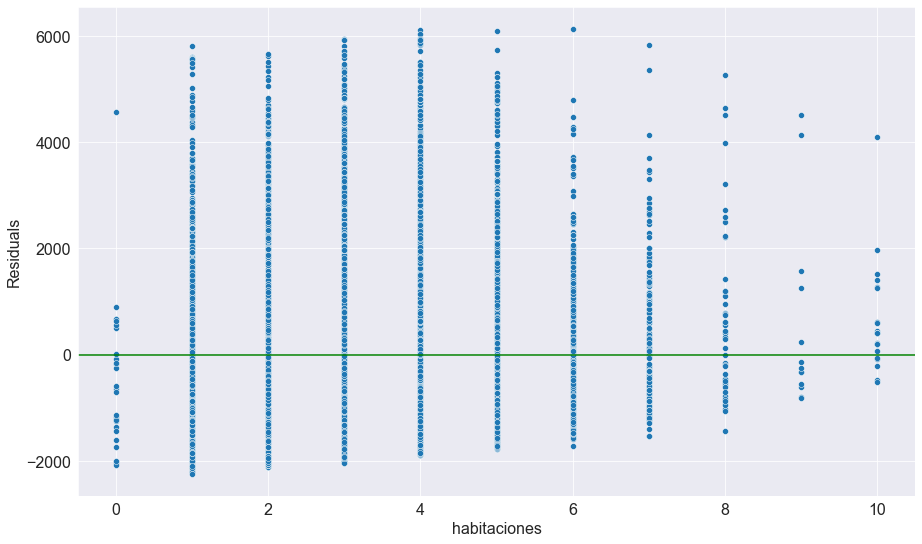

In [28]:
residuals_test("habitaciones", "precio_por_m2")

## Multicolinearidad



Para detectar multicolinealidad poder utilizar el factor de inflación de varianza (VIF). 
La interpretación de VIF es la siguiente: la raíz cuadrada de un VIF de una variable dada muestra cuánto más grande es el error estándar, en comparación con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo. Si no se correlacionan características, todos los valores para VIF serán 1.
Para lidiar con la multicolinealidad, debemos eliminar iterativamente las características con valores altos de VIF. Una regla general para la eliminación podría ser VIF mayor de 10 (5 también es común). 

In [29]:
#multicolinearidad uso IVF(inflación de varianza) muestra cuánto más grande es el error estándar, en comparación 
#con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo . 
#Si no se correlacionan características, todos los valores para VIF serán 1.

from statsmodels.stats.outliers_influence import variance_inflation_factor

def multicolinearidad_test (X):
  X_constant = sm.add_constant(X)
  vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
  return (pd.DataFrame({'vif': vif[1:]}, index=X.columns).T)

In [30]:
multicolinearidad_test(data[['sup_total','sup_cubierta','habitaciones']])

,sup_total,sup_cubierta,habitaciones
vif,2.479854,2.70879,1.249485


## Homocedasticidad

Para investigar si los residuos presentan igual varianza, podemos observar una gráfica de los residuos (o residuos estandarizados) frente a los valores predichos (ajustados) como hicimos en la figura anterior cuando chequeabamos la linealidad del modelo. Lo que debería alarmarnos es el caso cuando los residuos crecen ya sea en función del valor pronosticado o del tiempo (en el caso de series de tiempo).

También podemos usar dos pruebas estadísticas: Breusch-Pagan y Goldfeld-Quandt. En ambos, la hipótesis nula supone la homocedasticidad y un valor p por debajo de cierto nivel (como 0.05) indica que debemos rechazar el nulo a favor de la heterocedasticidad.

In [31]:
#homocedasticidad
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)


def homoscedasticity_test(features, target):
    X = data[features]
    y = data[target]
   
    model = sm.OLS(y,X).fit()
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    #Breusch-Pagan Test
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    #Goldfeld-Quandt test
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  8529.725649
p-value                           0.000000
f-value                        3572.803825
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.992474
p-value      0.707385

 Residuals plots ----


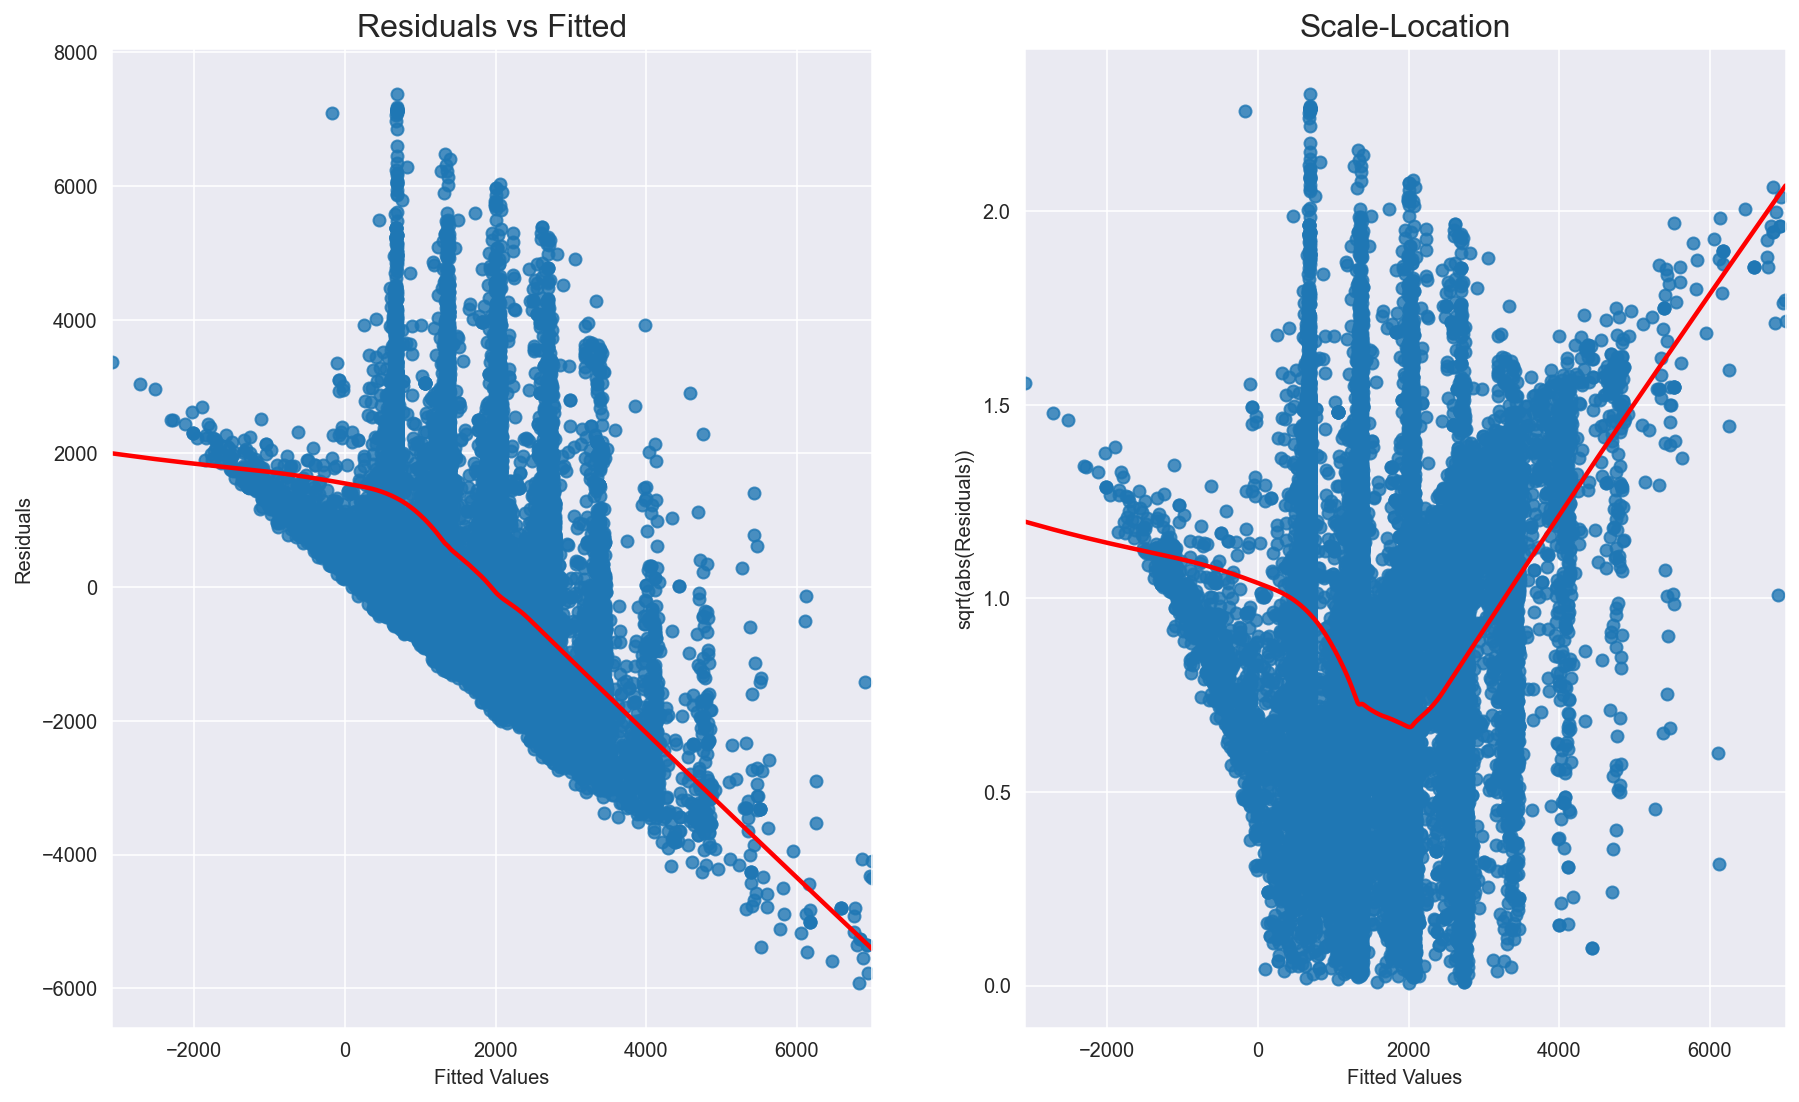

In [32]:
homoscedasticity_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])

## Autocorrelación

Para investigar si la autocorrelación está presente, utilizo gráficos ACF (función de autocorrelación) y la prueba de Durbin-Watson. En el primer caso, queremos ver si el valor de ACF es significativo para cualquier retraso (en caso de que no haya datos de series temporales, se utiliza el número de fila). Al llamar a la función, indicamos el nivel de significación en el que estamos interesados y el área crítica se traza en el gráfico. Las correlaciones significativas se encuentran fuera de esa área.

Algunas notas sobre la prueba de Durbin-Watson:

- El estadistico de prueba siempre tiene un valor entre 0 y 4
- El valor de 2 significa que no hay autocorrelación en la muestra
- Valores <2 indican autocorrelación positiva, valores > 2 negativo uno. Si vamos a la celda donde obtuvimos el modelo vemos un DW = 1.016



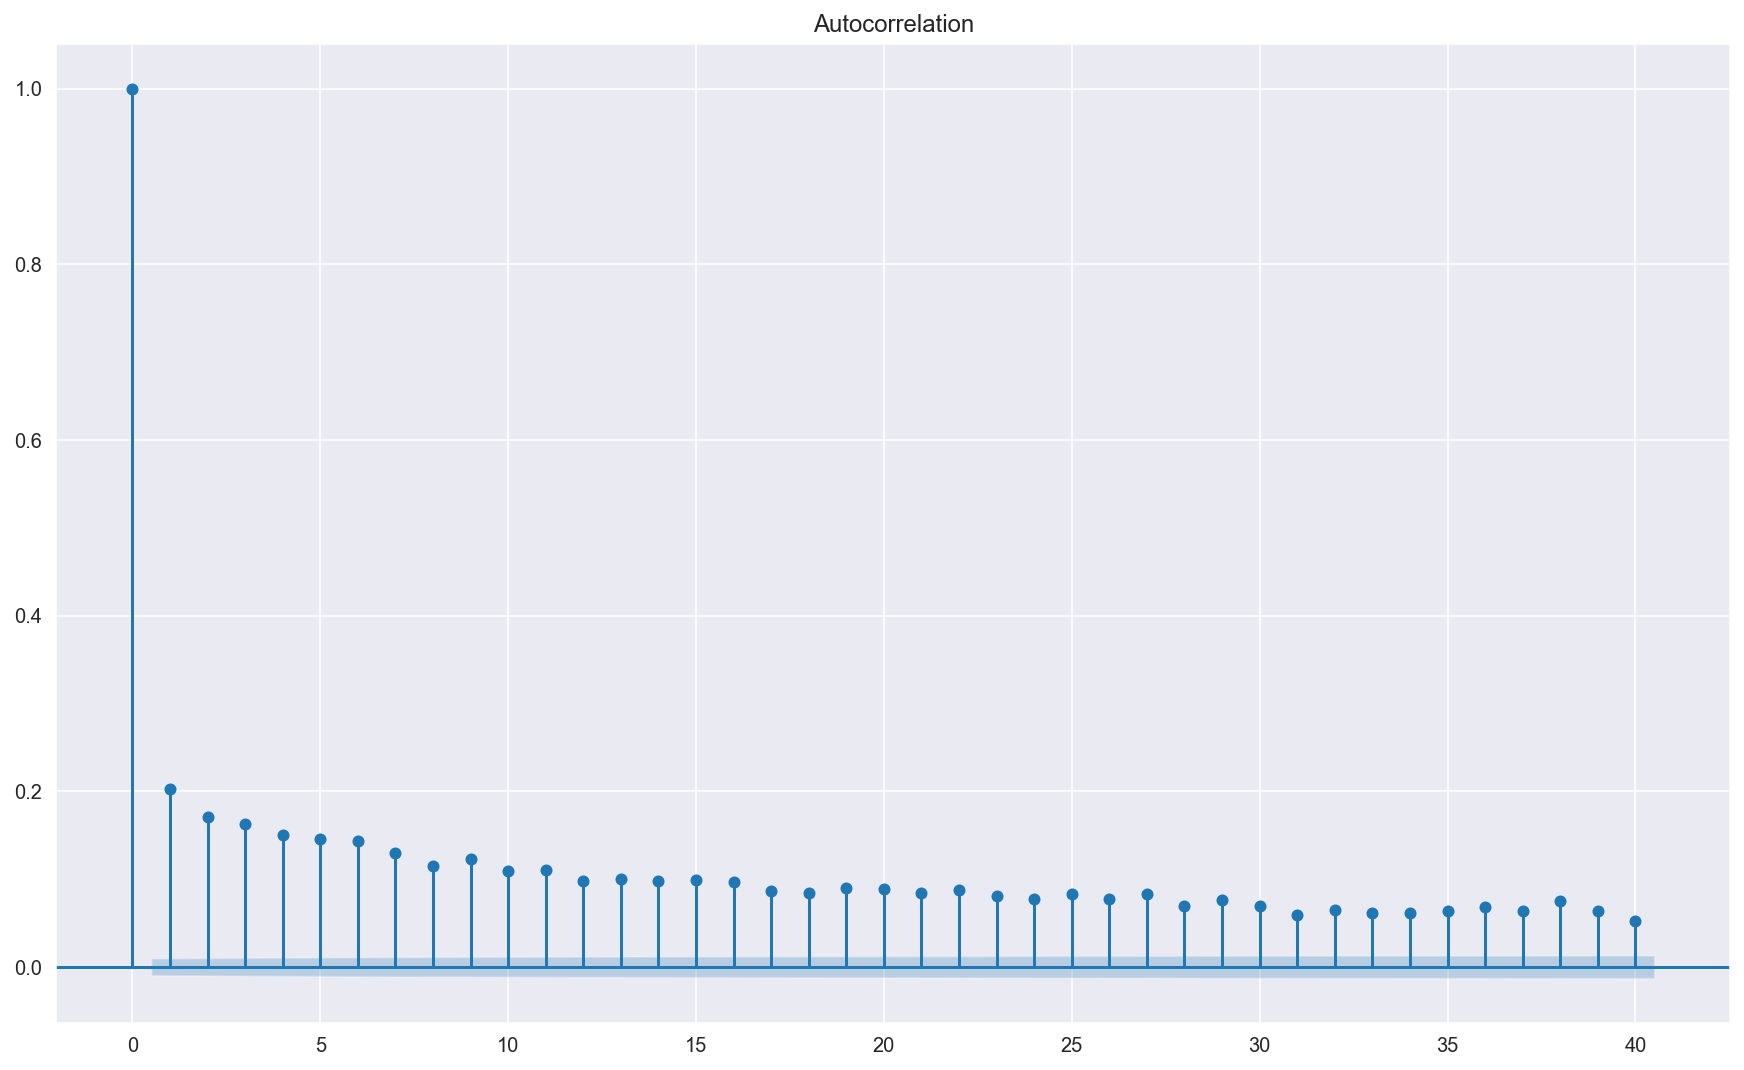

In [33]:
#autocorrelacion
import statsmodels.tsa.api as smt

X = data[['sup_total','sup_cubierta','habitaciones']]
y = data["precio_por_m2"]
model = sm.OLS(y,X).fit()

acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
#acf.show();

## Normalidad de los residuos

Cuando se viola este supuesto , puede causar problemas al calcular los intervalos de confianza y varias pruebas de significancia para los coeficientes. Cuando la distribución del error se aleja significativamente de Gauss, los intervalos de confianza pueden ser demasiado amplios o demasiado estrechos. Algunas de las posibles razones que causan residuos no normales:

- Presencia de algunos valores atípicos grandes en los datos
- Puede haber otros problemas (violaciones) con los supuestos del modelo
- Otra mejor especificación del modelo podría ser más adecuada para este problema.

Para investigar esta suposición podemos mirar:

- Gráficos QQ de los residuos. Por ejemplo, un patrón de desviaciones en forma de arco de la diagonal implica que los residuos tienen una inclinación excesiva (es decir, la distribución no es simétrica, con demasiados residuos grandes en una dirección). El patrón de desviaciones en forma de s implica una curtosis excesiva de los residuos: hay demasiados o dos pocos errores grandes en ambas direcciones.
- Pruebas estadísticas como la prueba de Kolmogorov-Smirnov, la prueba de Shapiro-Wilk, la prueba de Jarque-Bera y la prueba de Anderson-Darling pueden ser utiles para evaluar este supuesto.

Posibles soluciones:
- transformación no lineal de la variable o características objetivo
- eliminar / tratar posibles valores atípicos
- Puede suceder que haya dos o más subconjuntos de datos que tengan propiedades estadísticas diferentes, en cuyo caso podrían considerarse modelos separados

In [34]:
#normalidad de los residuos
from scipy import stats

def normality_of_residuals_test(features, target):
    X = data[features]
    y = data[target]
    model = sm.OLS(y,X).fit()
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

C:\Users\maela\anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 2217.9125, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9923, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6274, p-value: 0.0000
Anderson-Darling test ---- statistic: 40.7737, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


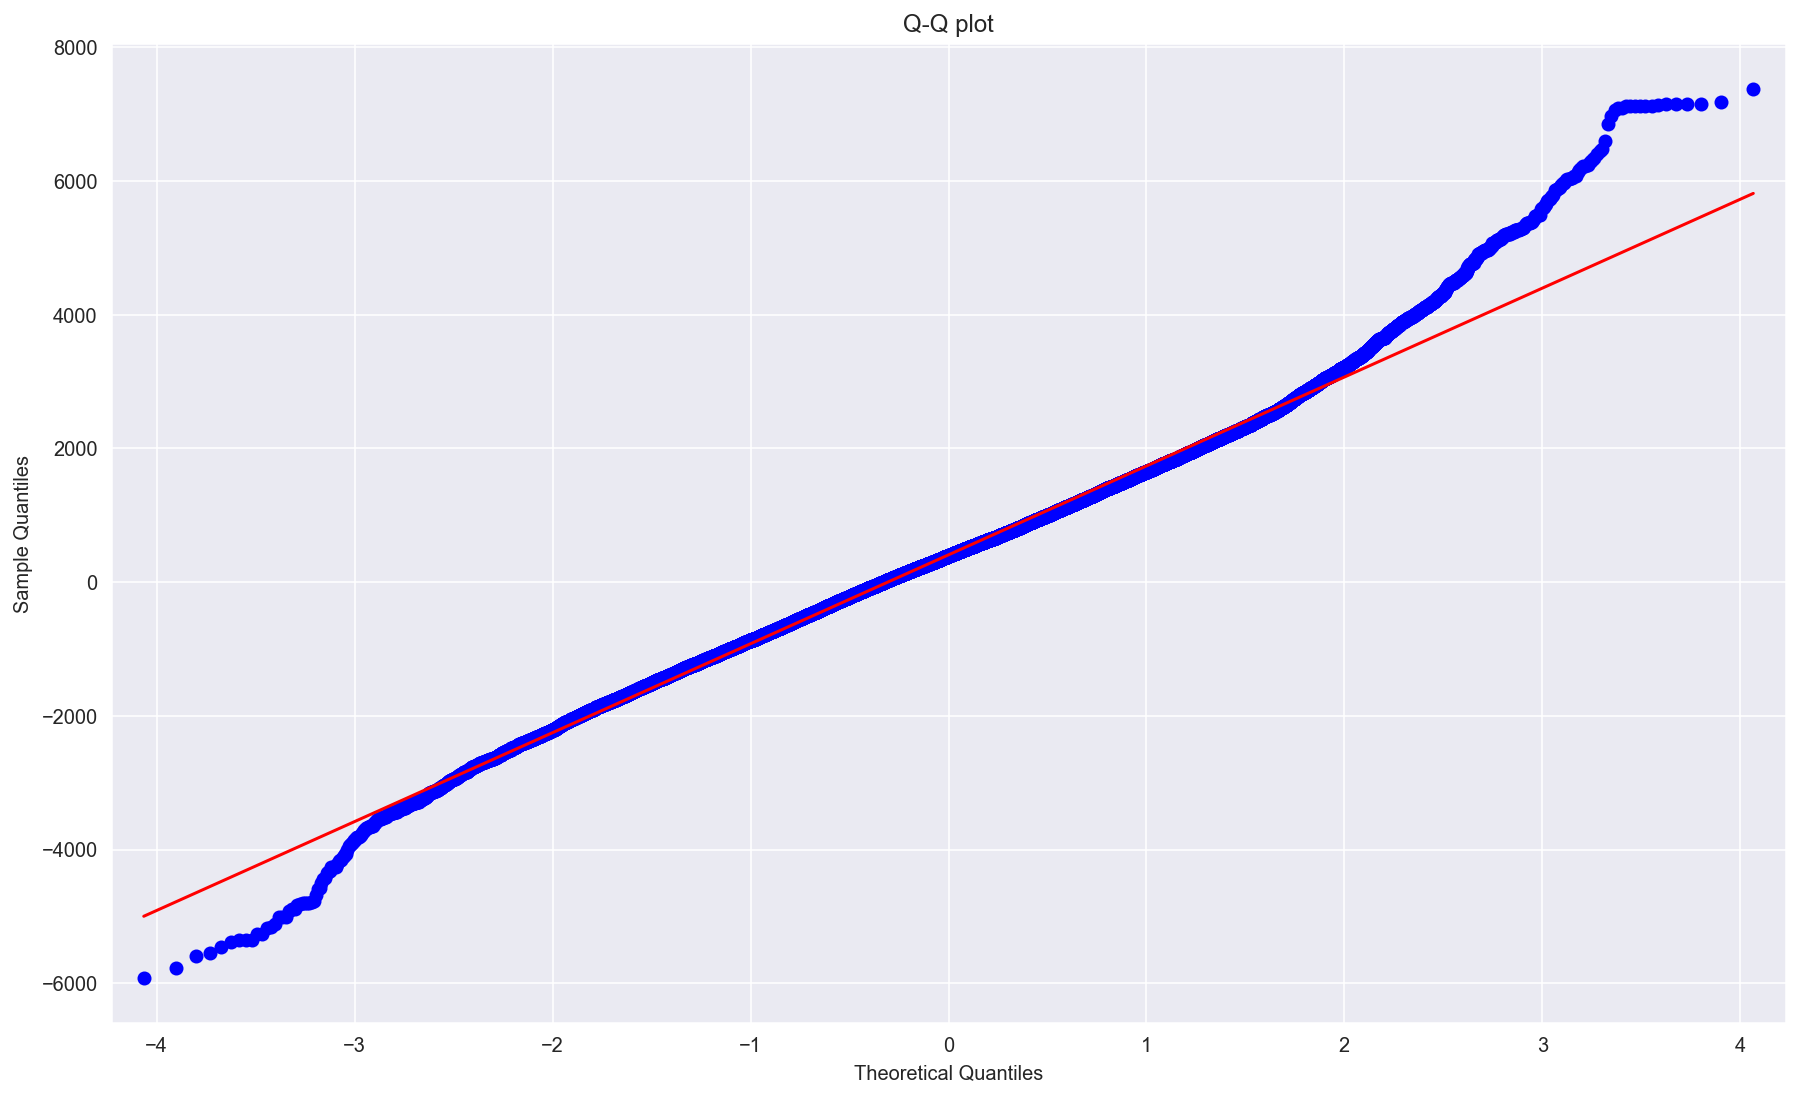

In [35]:
normality_of_residuals_test(['sup_total','sup_cubierta','habitaciones'], ["precio_por_m2"])

<AxesSubplot:ylabel='Density'>

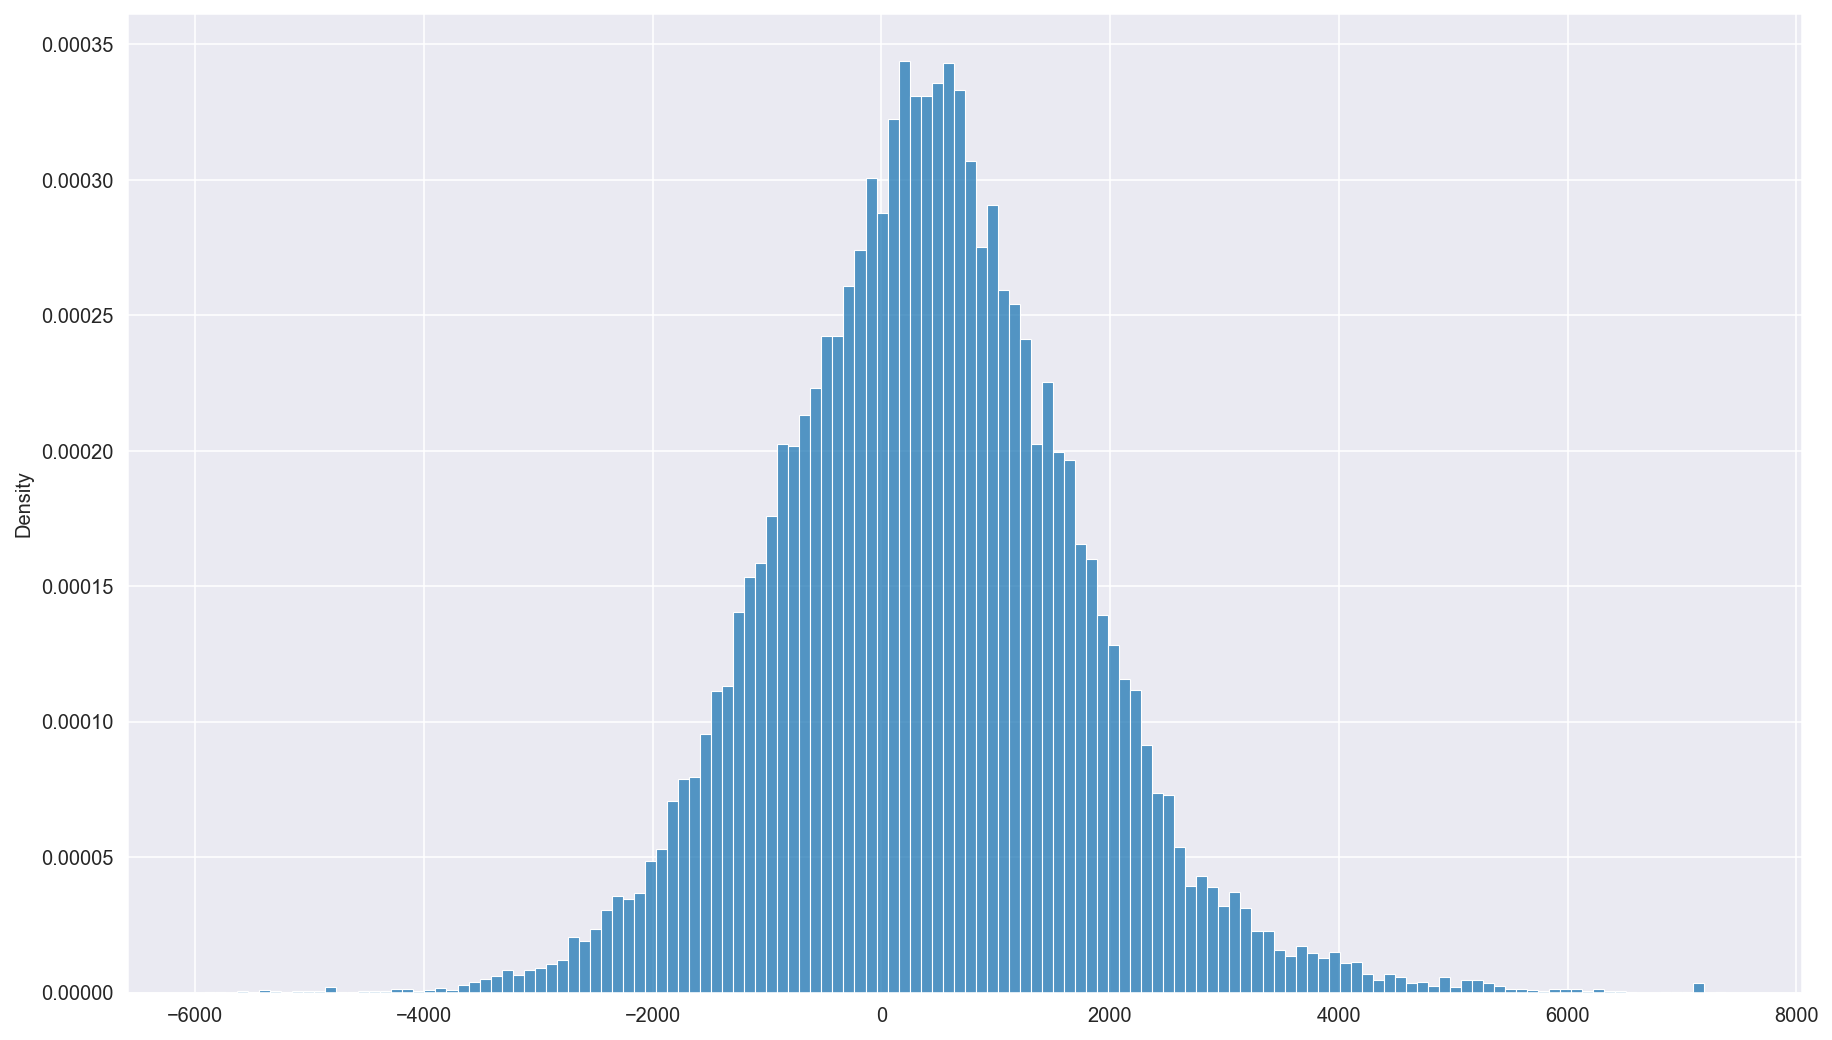

In [36]:
sns.histplot(model.resid, kde = False, stat = 'density', line_kws={'linewidth':5})